Імпорт бібліотек

In [101]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt

Підготовка даних

In [102]:
df = pd.read_csv('dataset_pcs.csv')

In [103]:
df['period'] = pd.to_datetime(df['period'], errors='coerce')

In [104]:
# Приведення revenue до float
df['revenue'] = df['revenue'].astype(str).str.replace(',', '.').astype(float)

# Обчислення ціни з уникненням ділення на нуль
df['price'] = df.apply(
    lambda row: row['revenue'] / row['qty_total'] if row['qty_total'] != 0 else np.nan,
    axis=1
)

# Повторна підстановка середньої ціни по SKU, якщо price некоректна (0 або NaN)
mean_prices = df[df['price'] > 0].groupby('sku_id')['price'].mean()
results['price'] = results.apply(
    lambda row: mean_prices[row['sku_id']] if (pd.isna(row['price']) or row['price'] == 0) and row['sku_id'] in mean_prices else row['price'],
    axis=1
)


In [105]:
forecast_dates = pd.to_datetime(['2025-02-03', '2025-02-10', '2025-02-17', '2025-02-24'])

Виділення тренувального періоду і тестового періоду

In [106]:
cutoff_date = pd.to_datetime('2025-01-31')
train_df = df[df['period'] <= cutoff_date]
test_df = df[df['period'].isin(forecast_dates)]

Запуск моделі

In [107]:
sku_ids = train_df['sku_id'].unique()
forecast_results = []

for sku in tqdm(sku_ids, desc='Forecasting SKUs'):
    sku_train = train_df[train_df['sku_id'] == sku][['period', 'qty_total']].rename(columns={'period': 'ds', 'qty_total': 'y'})
    
    # Skip SKUs with insufficient data
    if sku_train['y'].count() < 10 or sku_train['y'].nunique() <= 1:
        continue

    model = Prophet(daily_seasonality=True)
    try:
        model.fit(sku_train)
        future = pd.DataFrame({'ds': forecast_dates})
        forecast = model.predict(future)[['ds', 'yhat']]
        forecast['sku_id'] = sku
        forecast_results.append(forecast)
    except Exception as e:
        print(f"⚠️ Skipped SKU {sku}: {e}")
        continue


forecast_df = pd.concat(forecast_results, ignore_index=True)

Forecasting SKUs:   0%|          | 0/463 [00:00<?, ?it/s]18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
Forecasting SKUs:   0%|          | 2/463 [00:00<00:42, 10.88it/s]18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
Forecasting SKUs:   1%|          | 4/463 [00:00<00:38, 11.78it/s]18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
Forecasting SKUs:   1%|▏         | 6/463 [00:00<00:38, 11.74it/s]18:53:52 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cm

Об'єднання результатів прогнозу з фактом

In [108]:

actuals_df = test_df[['period', 'sku_id', 'qty_total', 'revenue', 'price']].rename(columns={'period': 'ds'})
results = pd.merge(forecast_df, actuals_df, on=['sku_id', 'ds'], how='inner')

# Якщо price == 0, підставляємо середню ціну по кожному SKU
mean_prices = df[df['price'] > 0].groupby('sku_id')['price'].mean()
results['price'] = results.apply(
    lambda row: mean_prices[row['sku_id']] if row['price'] == 0 and row['sku_id'] in mean_prices else row['price'],
    axis=1
)

# Перерахунок forecasted_revenue
results['forecasted_revenue'] = results['yhat'] * results['price']

Розрахунок Метрик

In [109]:
# Перетворення revenue у float
results['revenue'] = results['revenue'].astype(str).str.replace(',', '.').astype(float)

# Обчислення метрик
results['abs_error'] = (results['qty_total'] - results['yhat']).abs()
results['pct_error'] = results['abs_error'] / results['qty_total'].replace(0, np.nan)
results['weighted_error'] = results['abs_error'] * results['revenue']

results_clean = results.dropna(subset=['yhat', 'qty_total', 'revenue'])
results_valid_wmape = results_clean[results_clean['revenue'] > 0]

mae = results_clean['abs_error'].mean()
mape = results_clean['pct_error'].mean() * 100  # у %
wmape = results_valid_wmape['weighted_error'].sum() / results_valid_wmape['revenue'].sum() * 100  # у %

Відобреження результатів (Вибираємо одну - мені відправляємо в ДЗ)

МАЕ

In [110]:
print(f"📌 MAE: {mae:.2f} units")

📌 MAE: 1.07 units


МАРЕ

In [111]:
print(f"📌 MAPE: {mape:.2f}%")

📌 MAPE: 80.99%


WMAPE

In [112]:
print(f"📌 WMAPE: {wmape:.2f}%")

📌 WMAPE: 534.47%


Візуалізація результатів

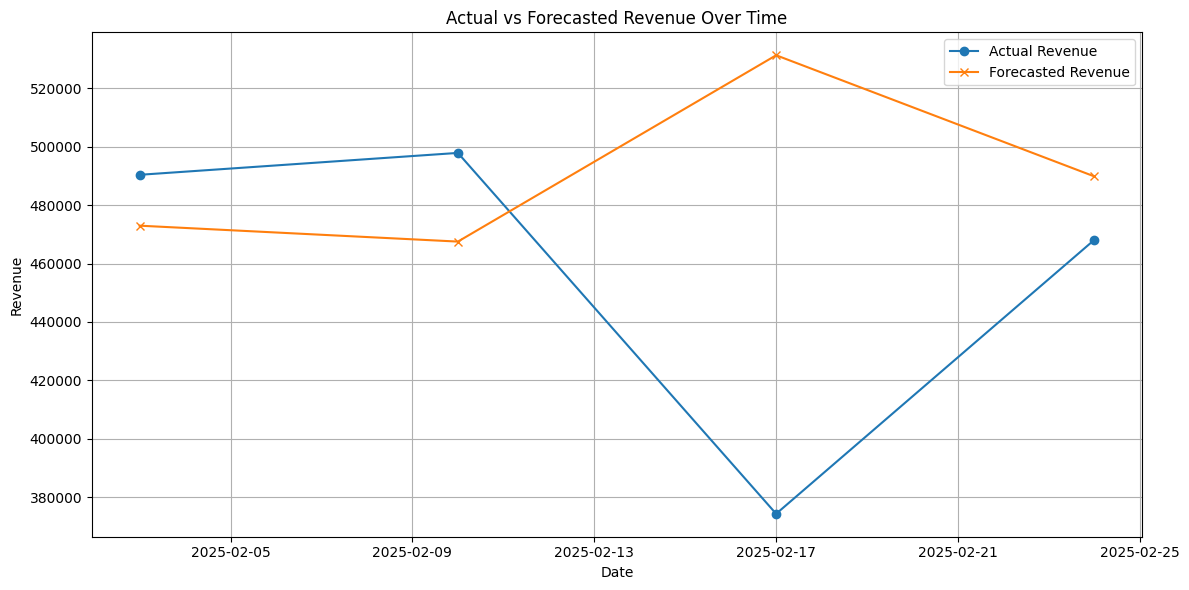

In [113]:
# Вилучаємо нульові або NaN forecasted_revenue
filtered_results = results[(results['forecasted_revenue'] > 0) & (~results['forecasted_revenue'].isna())]

# Агрегація після фільтрації
revenue_summary = filtered_results.groupby('ds').agg({
    'revenue': 'sum',
    'forecasted_revenue': 'sum'
}).reset_index()

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.plot(revenue_summary['ds'], revenue_summary['revenue'], marker='o', label='Actual Revenue')
plt.plot(revenue_summary['ds'], revenue_summary['forecasted_revenue'], marker='x', label='Forecasted Revenue')
plt.title('Actual vs Forecasted Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Завантаження прогнозу ретроспективи

In [114]:
results.to_csv('forecast_feb_2025_results.csv', index=False)
print("✅ Results saved to 'forecast_feb_2025_results.csv'")

✅ Results saved to 'forecast_feb_2025_results.csv'
